# LSH and Document Similarity

In this section, we test out the `alis.similarity.LSH` class on the [News Group Dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset) data available in `sklearn`. We initially follow the steps in the Minhashing section to get the minhash signatures of the dataset. Note that, here, only the first $2000$ documents are used for simplicity in inspection of similar items.

Since `alis.similarity` and `alis.feature_extraction` makes use of `dask`, we first initialize a `dask.distributed.Client`.

## Minhashing

In [1]:
from dask.distributed import Client
import dask.bag as db

client = Client()

We first load the dataset from `sklearn` and create a `dask.bag` with elements corresponding to `(identifier, text)` tuples. 

In [2]:
from sklearn.datasets import fetch_20newsgroups

# Load the news group dataset without the headers, footers and quotes
newsgroup = fetch_20newsgroups(
    subset='train', remove=('headers', 'footers', 'quotes'),
    random_state=11,
)
newsgroup_data = newsgroup['data'][0:2000] # load only first 3000 documents

newsgroup_bag = db.from_sequence(
    zip(range(len(newsgroup_data)), newsgroup_data))

We then implement a simple cleaning step that normalizes all the blank space characters into a single space and then removes all alpha-numeric characters. We also cast all the text to lowercase for simplicity. `dask.bag` allows for mapping a function onto its elements using the `.map()` method.

In [3]:
import re

def clean_text(text):
    """Clean text by removing non-alphanumeric characters and replacing
    all blank space characters into a single space
    """
    return (re.sub(r'\s', r' ', re.sub(r'[^\w\s]', r'', text)).lower())

In [4]:
newsgroup_bag_cleaned = newsgroup_bag.map(lambda x: (x[0], clean_text(x[1])))

We now apply minhashing onto the text of each document in `newsgroup_bag_cleaned`. This is done by simply using the `MinhashLSH` class' `transform()` method on the `dask.bag`. In thie example below, we instantiate the class by initializing the parameters for shingling (i.e., `shingle_size`) and for the minhashing step (i.e., `num_shingle_bucket`, `num_hash`, and `hash_size`. Since there are $12$ hashes, we can expect that the signature matrix returned by `transform()` for each document is of size $12$.

In [5]:
from alis.feature_extraction import MinhashLSH

In [6]:
minhasher = MinhashLSH(shingle_size=3, num_shingle_bucket=12, num_hash=12,
                       hash_size=2**12)

In [7]:
newsgroup_signatures = minhasher.transform(newsgroup_bag_cleaned)

We can inspect 10 random elements from the bag of signatures using `take(10)` method. Observe that indeed, signatures are all lists of size $12$, with elements in the bag as `(indentifier, signature)` tuples. 

In [8]:
newsgroup_signatures.take(10)

((0, [1494, 2469, 2651, 671, 507, 1425, 159, 417, 1644, 1514, 1163, 350]),
 (1, [33, 12, 196, 37, 8, 6, 6, 39, 6, 64, 15, 10]),
 (2, [4, 12, 26, 7, 38, 27, 15, 39, 6, 101, 1, 45]),
 (3, [47, 75, 46, 8, 21, 15, 69, 39, 66, 95, 88, 5]),
 (4, [40, 12, 36, 2, 85, 3, 15, 39, 11, 4, 0, 5]),
 (5, [8, 12, 1, 1, 13, 3, 15, 39, 28, 16, 15, 5]),
 (6, [1323, 264, 1836, 1364, 264, 999, 978, 1614, 2111, 2854, 799, 3095]),
 (7, [79, 12, 31, 87, 140, 144, 6, 39, 146, 62, 5, 135]),
 (8, [240, 138, 231, 47, 36, 324, 6, 228, 61, 24, 48, 15]),
 (9, [246, 75, 691, 94, 142, 765, 357, 291, 10, 56, 37, 405]))

The `minhasher.transform` step also filters the documents by taking only those that contain at least $1$ shingle. Hence we can observe that documents with fewer characters may not accomodate the `shingle_size` size chosen. Let's inspect the new size from the original $2000$ documents.

In [9]:
signatures_list = newsgroup_signatures.compute()
print("New Number of Documents: ", len(signatures_list))

New Number of Documents:  1927


## LSH Banding Technique

We now perform locality-sensitive hashing on the minhash signatures, specifically using the banding technique slicing the singatures of size $15$ into bands (i.e., `bands=3`). We then inspect and verify, using the `r` and `bands` attribute the diminsions of the each signature band.

In [10]:
from alis.similarity import LSH

lsh = LSH(newsgroup_signatures)
lsh.make_bands(bands=3)
print("Rows per band: ", lsh.r)
print("Number of bands: ", lsh.bands)

Rows per band:  4
Number of bands:  3


We then apply the `.get_buckets()` method, which is the per-band hashing step in the traditional LSH where we apply a hash function on each band that hashes the similar documents into the same bucket (i.e., candidate pairs). 

Inspecting the `buckets` show that we have a dictionary with keys as the band identifier and `dask.bag` as values.

In [11]:
buckets = lsh.get_buckets()
print("Group of buckets: ", len(buckets.keys()))

# inspect the structure of the buckets
display(buckets)

Group of buckets:  3


{0: dask.bag<lambda, npartitions=1>,
 1: dask.bag<lambda, npartitions=1>,
 2: dask.bag<lambda, npartitions=1>}

Lets further inspect the contents of the band identified as `0` using the `.take(10)` method. We can see that the elements are tuples of `(hash bucket, list of document identifiers)`. Elements of the list for each tuple correspond to documents that are hashed in that hash value. It follows that list contaning more than one element, surface candidate pairs.

In [12]:
buckets[0].repartition(10).take(10)

((5349837036471001827, [0]),
 (4061131334253544622, [1]),
 (-3201416287804991259, [2]),
 (6009770189650563317, [3]),
 (-6239275907353270376, [4]),
 (7074500024779176862, [5]),
 (9150421557748798632, [6]),
 (-1140712557129957939, [7]),
 (-5415297283791330710, [8]),
 (1150195895645989385, [9]))

In this section, we inspect the candidate pairs by showing only those hash buckets (i.e., hash values) whose lists of document identifiers have size greater than $1$ for each of the 3 bands. We surfaced a candidate pair for atleast one of the bands!

In [13]:
# candidate pair for band zero
buckets[0].filter(lambda x: len(x[1]) > 1).compute()

[(5323470252749634725, [1362, 1674]),
 (9133247501793010434, [1376, 1639, 1973]),
 (-5131043885278292129, [1402, 1530])]

In [14]:
# candidate pair for band 1
buckets[1].filter(lambda x: len(x[1]) > 1).compute()

[(9133247501793010434, [211, 1720]),
 (3328690425592746002, [431, 1855]),
 (5447225194283883763, [676, 1040]),
 (5323470252749634725, [1362, 1674])]

In [15]:
# candidate pair for band 2
buckets[2].filter(lambda x: len(x[1]) > 1).compute()

[(-8431313624916672304, [320, 1673]), (413562760039724022, [516, 1281, 1781])]

We can also inspect further by looking at the actual text, you can do so by printing `newsgroups[index]` where index are document identifiers surfaced to be candidate pairs.

We now inspect the s-curve: a plot showing the probability that some actual pairwise similarity will be considered a candidate pair. We see here the similiraty threshold which marks the minimum similarity value for a pair to be considered candidate. This threshold is dependent on the number of bands $b$ and the resulting number of rows $r$ and is approximated by ${1 / b}^{1/r}$.

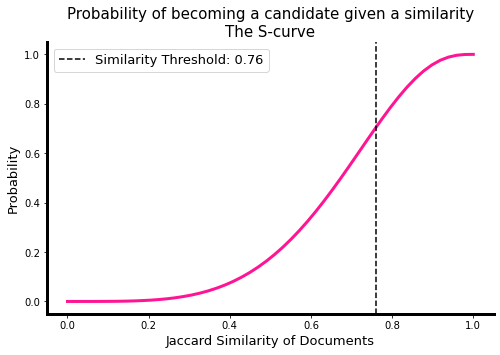

In [16]:
# plotting the s-curve
ax, thresh = lsh.plot_thresh(display_thresh=True, lw=3, c='deeppink')

## Exhaustive Search

We can do the exhaustive pairwise similarity calculation and verify that indeed, the similarity threshold shown in the figure above aligns with the distributio of actual similarities of documents in our corpus. For simplicity, we opted in calculating the similarities of signatures. *Note: Depending on your machine and the number of documents used, this exhaustive step may crash due to memory constraints.*

In [17]:
signatures_dict = {k:v for k, v in signatures_list}

In [18]:
from itertools import combinations
from scipy.spatial.distance import jaccard

def jaccard_sim(u, v):
    return 1 - jaccard(u, v)

similarities = [jaccard_sim(signatures_dict[u_idx], signatures_dict[v_idx]) \
                for u_idx, v_idx in combinations(list(signatures_dict.keys()), 2)]


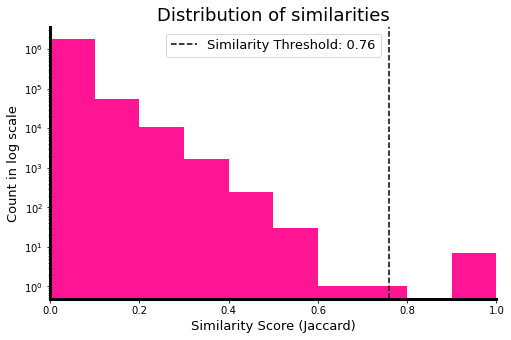

In [19]:
# jaccard similarity distribution
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(8, 5))
ax.hist(similarities, bins=10, log=True, color='deeppink')
ax.set_title('Distribution of similarities', fontsize=18)
ax.set_xlabel('Similarity Score (Jaccard)', fontsize=13)
ax.set_ylabel('Count in log scale', fontsize=13)
ax.set_xlim(0,1)
ax.axvline(thresh, color='black', linestyle='--',
                       label=f'Similarity Threshold: {thresh:.2f}')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set spines lw
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax.legend(fontsize=13)
plt.show()

To further verifiy, let's count the number of documents whose similarity is greater than the threshold. You can further verfiy by inspecting the actual similirity of the candidate pairs surfaced.

In [20]:
import numpy as np
# display the similarity value above the approx thresh
num_candidate_pairs = (np.array(similarities) > thresh).sum()
print("Number of docs exceeding the simiarlity threshold: ", num_candidate_pairs)

Number of docs exceeding the simiarlity threshold:  7


## Final note for LSH

You may observe that some documents `LSH` classed as candidate pairs, may have actual similarities less than the threshold. This presents the trade-off between efficiency and the accuracy of similarity classification--whereas, the banding technique may surface false negatives and false positives. False negatives occur when the banding strategy used does not align with the similarity threshold that we expect. However, this can be addressed by calculating the approximate threshold which is shown in the plots. False positives occur because of the more tolerant condition wherein we considered a pair as candidates if they are hashed in the same bucket for at least one band. This can be addressed by adding an exhaustive similarity search on the smaller subset of pairs--the candidate pairs.